# Comparison of original CNN and new PyTorch CNN
  PyTorch CNN trains with CosAnnealingWithWarmRestarts scheduler 
  The experiment plot: 
  <pre>
                                   ┌> PT CNN ─Training─> Trained PT CNN ─────┬────> Stats 
                                   |                                         |
  DATASET (70 seqs of 10 families) |                    TEST DATASET (67 seqs of 10 families)                 
                                   |                                         |
                                   └> Ch CNN ─Training─> Trained Ch CNN ─────┴────> Stats
  </pre>

In [1]:
import sys
import os
# appending source path 
sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1] + ["src"]))
sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1] + ["src", "original_cnn"]))

In [2]:
import RunNN  # our cnn
from DataProcessing import AlignmentFilePrepare  # dataset class

from torch.utils.data import DataLoader

import json
from subprocess import Popen, PIPE
from collections import defaultdict
from itertools import combinations
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd


# IMPORTANT CONSTANTS
BATCH_SIZE= 128
EPOCH = 15
CPU_ONLY = False


def prediction_stats(predicted, true_labels):
    # get stats
    pred_aff = np.fromiter(map(lambda t: (t[1]==t[0]), combinations(predicted, 2)), dtype=np.int8)
    true_aff = np.fromiter(map(lambda t: (t[1]==t[0]), combinations(true_labels, 2)), dtype=np.int8)
    tp = np.sum(np.logical_and(true_aff, pred_aff))
    tn = np.sum(np.logical_and(np.logical_not(true_aff), np.logical_not(pred_aff)))
    fn = np.sum(np.logical_and(true_aff, np.logical_not(pred_aff)))
    fp = np.sum(np.logical_and(np.logical_not(true_aff), pred_aff))
    print("ACC: {:.4f}%".format(100*(tn+tp)/(tp+tn+fp+fn)))
    print("F1: {:.4f}".format(2*tp/(2*tp+fn+fp)))
    print(
    """
    pred\\real\t1\t0
            1\t{}\t{}
            0\t{}\t{}
             \t{:.2f}\t{:.2f}
    """.format(tp, fp, fn, tn, (tp+fn)/(tp+fn+tn+fp), 1-(tp+fn)/(tp+fn+tn+fp)))

## Prepare datasets
Please, stand by

In [3]:
# training ds
cmd = [
    "python",
    "../src/original_cnn/prepareData.py",
    "-i", "../data/train.fasta",
    "-o", "../data/train",
    "-t", "3"  # adjust threads
]
with Popen(cmd) as proc:
    print("Return code is {}".format(proc.wait()))

# test ds
cmd = [
    "python",
    "../src/original_cnn/prepareData.py",
    "-i", "../data/test.fasta",
    "-o", "../data/test",
    "-t", "3"  # adjust threads
]
with Popen(cmd) as proc:
    print("Return code is {}".format(proc.wait()))
    

Return code is 0
Return code is 0


## Train and test RunNN
### DAFS with nucleotide alignments

In [4]:
# train model
model = RunNN.main(
    dataset="../data/train/ncRNApair_data.npy",
    label="../data/train/ncRNApair_labe.npy",
    genelabel="../data/train/genelabel.txt",
    batchsize=BATCH_SIZE,
    epoch=EPOCH,
    vpart=0.1,
    cpu=CPU_ONLY,
    structure=False,
    predictor=""  # empty, if you want to train model
)
# evaluate model
dataset = AlignmentFilePrepare("../data/test/ncRNApair_data.npy", "../data/test/ncRNApair_labe.npy", "../data/test/genelabel.txt")
dl = DataLoader(dataset, num_workers=3, shuffle=False, batch_size=BATCH_SIZE)
RunNN.predict(model, dl)
# save stats
with open("stats.json") as fin:
    dafs_pt_cnn_history = json.load(fin)
dafs_pt_cnn_results = RunNN.predict(model, dl)
for key, val in dafs_pt_cnn_results.items():
    if key != "PREDICTIONS":
        print("{}:\t{}".format(key, val))
# clean space
del model

# clustering test
aff_matrix = defaultdict(dict)
families = dict()
for tup in dafs_pt_cnn_results["PREDICTIONS"]:
    aff_matrix[tup[0]][tup[1]] = tup[4].item()
    families[tup[0]] = tup[2].item()
aff_df = pd.DataFrame(aff_matrix).fillna(0).sort_index()
fam_df = pd.DataFrame.from_dict(families, orient="index").sort_index()
clusterer = KMeans(n_clusters=10).fit(aff_df)
prediction_stats(clusterer.labels_, np.squeeze(fam_df.values))

Dataset splitted. Classes distributed: chi^2 p-val=1.0 (1 means equally distributed classes in test and validation)
Data loaded:
	Train: 4347 alignments
	Validation: 483 alignments
Negatives in training set: 91.26%. In val set: 91.72%
Data is loaded. Shape: torch.Size([1, 1200, 16])
Epoch [1/15], Loss (train/val): 0.2505/0.1785, Accuracy (train/val): 89.5357%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 3.55
Epoch [2/15], Loss (train/val): 0.1182/0.0600, Accuracy (train/val): 95.1718%/97.7226%, Precision (val): 0.9758, Current lr: 0.00051. Time elapsed: 5.87
Epoch [3/15], Loss (train/val): 0.0292/0.0137, Accuracy (train/val): 99.1039%/99.3789%, Precision (val): 0.9933, Current lr: 0.00051. Time elapsed: 7.55
Epoch [4/15], Loss (train/val): 0.0142/0.0055, Accuracy (train/val): 99.4485%/99.5859%, Precision (val): 1.0000, Current lr: 0.00051. Time elapsed: 9.24
Epoch [5/15], Loss (train/val): 0.0019/0.0063, Accuracy (train/val): 99.9770%/99.5859%, Precision (val):

### DAFS structure-only

In [5]:
# train model
model = RunNN.main(
    dataset="../data/train/ncRNApair_data.npy",
    label="../data/train/ncRNApair_labe.npy",
    genelabel="../data/train/genelabel.txt",
    batchsize=BATCH_SIZE,
    epoch=EPOCH,
    vpart=0.1,
    cpu=CPU_ONLY,
    structure=True,
    predictor=""  # empty, if you want to train model
)
# evaluate model
dataset = AlignmentFilePrepare("../data/test/ncRNApair_data.npy", "../data/test/ncRNApair_labe.npy", "../data/test/genelabel.txt", structure=True)
dl = DataLoader(dataset, num_workers=3, shuffle=True, batch_size=BATCH_SIZE)
RunNN.predict(model, dl)
# save stats
with open("stats.json") as fin:
    struct_pt_cnn_history = json.load(fin)
struct_pt_cnn_results = RunNN.predict(model, dl)
for key, val in struct_pt_cnn_results.items():
    if key != "PREDICTIONS":
        print("{}:\t{:.4f}".format(key, val))
del model

# clustering test
aff_matrix = defaultdict(dict)
families = dict()
for tup in struct_pt_cnn_results["PREDICTIONS"]:
    aff_matrix[tup[0]][tup[1]] = tup[4].item()
    families[tup[0]] = tup[2].item()
aff_df = pd.DataFrame(aff_matrix).fillna(0).sort_index()
fam_df = pd.DataFrame.from_dict(families, orient="index").sort_index()
clusterer = KMeans(n_clusters=10).fit(aff_df)
prediction_stats(clusterer.labels_, np.squeeze(fam_df.values))

Dataset splitted. Classes distributed: chi^2 p-val=1.0 (1 means equally distributed classes in test and validation)
Data loaded:
	Train: 4347 alignments
	Validation: 483 alignments
Negatives in training set: 91.26%. In val set: 91.72%
Data is loaded. Shape: torch.Size([1, 1200, 6])
Epoch [1/15], Loss (train/val): 0.2842/0.2160, Accuracy (train/val): 91.0274%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 1.54
Epoch [2/15], Loss (train/val): 0.1433/0.1009, Accuracy (train/val): 93.9962%/96.0663%, Precision (val): 0.9862, Current lr: 0.00051. Time elapsed: 3.15
Epoch [3/15], Loss (train/val): 0.0731/0.0392, Accuracy (train/val): 97.1259%/98.9648%, Precision (val): 0.9910, Current lr: 0.00051. Time elapsed: 5.09
Epoch [4/15], Loss (train/val): 0.0306/0.0299, Accuracy (train/val): 98.9651%/99.1718%, Precision (val): 0.9955, Current lr: 0.00051. Time elapsed: 6.54
Epoch [5/15], Loss (train/val): 0.0203/0.0227, Accuracy (train/val): 99.1948%/98.9648%, Precision (val): 

## ClustalO data
Before run you should have data prepared via PairwiseClustalo_GettingMatrices

In [12]:
# train model
model = RunNN.main(
    dataset="../data/train/ncRNApair_data_clustal.npy",
    label="../data/train/ncRNApair_labe_clustal.npy",
    genelabel="../data/train/genelabel_clustal.txt",
    batchsize=BATCH_SIZE,
    epoch=EPOCH,
    vpart=0.1,
    cpu=CPU_ONLY,
    structure=False,
    predictor=""  # empty, if you want to train model
)
# evaluate model
dataset = AlignmentFilePrepare("../data/test/ncRNApair_data_clustal_test.npy", "../data/test/ncRNApair_label_clustal_test.npy", "../data/test/genelabel_clustal_test.txt")
dl = DataLoader(dataset, num_workers=3, shuffle=True, batch_size=BATCH_SIZE)
RunNN.predict(model, dl)
# save stats
with open("stats.json") as fin:
    struct_pt_cnn_history = json.load(fin)
struct_pt_cnn_results = RunNN.predict(model, dl)
for key, val in struct_pt_cnn_results.items():
    if key != "PREDICTIONS":
        print("{}:\t{:.4f}".format(key, val))
del model

# clustering test
aff_matrix = defaultdict(dict)
families = dict()
for tup in struct_pt_cnn_results["PREDICTIONS"]:
    aff_matrix[tup[0]][tup[1]] = tup[4].item()
    families[tup[0]] = tup[2].item()
aff_df = pd.DataFrame(aff_matrix).fillna(0).sort_index()
fam_df = pd.DataFrame.from_dict(families, orient="index").sort_index()
clusterer = KMeans(n_clusters=10).fit(aff_df)
prediction_stats(clusterer.labels_, np.squeeze(fam_df.values))

Dataset splitted. Classes distributed: chi^2 p-val=1.0 (1 means equally distributed classes in test and validation)
Data loaded:
	Train: 4347 alignments
	Validation: 483 alignments
Negatives in training set: 91.26%. In val set: 91.72%
Data is loaded. Shape: torch.Size([1, 1200, 10])
Epoch [1/15], Loss (train/val): 0.3188/0.2882, Accuracy (train/val): 90.1331%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 2.12
Epoch [2/15], Loss (train/val): 0.2907/0.2852, Accuracy (train/val): 91.2572%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 4.17
Epoch [3/15], Loss (train/val): 0.2935/0.2805, Accuracy (train/val): 91.2590%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 5.76
Epoch [4/15], Loss (train/val): 0.2687/0.2720, Accuracy (train/val): 91.2618%/91.7184%, Precision (val): 0.9172, Current lr: 0.00051. Time elapsed: 7.35
Epoch [5/15], Loss (train/val): 0.2550/0.2696, Accuracy (train/val): 91.5071%/92.1325%, Precision (val):

## Train and test original CNN
### Train
Clustering was not performed due to poor code documentation

In [6]:
# run train
# please, stand by
cmd = [
    "python",
    "../src/original_cnn/RNApairClassify.py",
    "-d", "../data/train/ncRNApair_data.npy",
    "-l", "../data/train/ncRNApair_labe.npy",
    "-gl", "../data/train/genelabel.txt",
    "-b", str(BATCH_SIZE),
    "-e", str(EPOCH),
    "-v", "6",  # the max value, which does not fail
    "-g", "0",  # adjust the GPU id
    "-o", "../data/results_train",
]
with Popen(cmd, stdout=PIPE, stderr=PIPE) as proc:
    print("Return code is {}".format(proc.wait()))
    print("Errors: {}".format("".join(proc.communicate()[1].decode("utf-8"))))

Return code is 0
Errors: 


### Test

In [7]:
cmd = [
    "python",
    "../src/original_cnn/RNApairClassify.py",
    "-d", "../data/test/ncRNApair_data.npy",
    "-l", "../data/test/ncRNApair_labe.npy",
    "-gl", "../data/test/genelabel.txt",
    "-g", "0",  # adjust the GPU id
    "-v", "1",  # use all data for test
    "-p", "../data/results_train/validation5/model_epoch-{}".format(EPOCH),
    "-o", "../data/results_test",
]
with Popen(cmd, stdout=PIPE, stderr=PIPE) as proc:
    print("Return code is {}".format(proc.wait()))
    print("Errors: {}".format("".join(proc.communicate()[1].decode("utf-8"))))

Return code is 0
Errors: 


## Clustering
### Spectral clustering on DAFS scores
#### Load sequences and make pairs

In [8]:
import numpy as np
from sklearn.cluster import SpectralClustering
from Bio import SeqIO
from subprocess import Popen, PIPE
from itertools import combinations

sequences = list(SeqIO.parse("../data/test.fasta", "fasta"))
pairs = combinations(enumerate(sequences), 2)

In [ ]:
sim_matrix = np.identity(len(sequences))
# run dafs
for pair in pairs:
    SeqIO.write((pair[0][1], pair[1][1]), "pair.fasta", "fasta")
    with Popen(["dafs", "pair.fasta"], stdout=PIPE) as proc:
        result = proc.communicate()[0].decode("utf-8")
        sim_matrix[pair[0][0], pair[1][0]] = float(result.split()[1])
        sim_matrix[pair[1][0], pair[0][0]] = float(result.split()[1])
# clean workspace
! rm pair.fasta

In [ ]:
np.save("../data/sim_matrix_dafs.npy", sim_matrix)  # save for future

In [11]:
sim_matrix = np.load("../data/sim_matrix_dafs.npy")
clusterer = SpectralClustering()
clusterer.fit(sim_matrix)
true_labels = list()
for seq in sequences:
    true_labels.append(int(seq.id.split(",")[1]))
prediction_stats(clusterer.labels_, true_labels)

/home/ilbumi/anaconda3/envs/sci/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


ACC: 93.1253%
F1: 0.7085

    pred\real	1	0
            1	158	125
            0	5	1603
             	0.09	0.91
    


# Visualisation

In [14]:
import altair as alt

### Epoch history

In [18]:
history = pd.DataFrame({k: dafs_pt_cnn_history[k] for k in dafs_pt_cnn_history if "epoch" in k or "val" in k})
history

,epoch_loss,epoch_acc,val_loss,val_prec,val_acc
0,0.250489,0.895357,0.178468,0.917184,0.917184
1,0.118197,0.951718,0.059990,0.975771,0.977226
2,0.029206,0.991039,0.013702,0.993274,0.993789
3,0.014215,0.994485,0.005469,1.000000,0.995859
4,0.001919,0.999770,0.006326,0.995506,0.995859
5,0.000406,1.000000,0.002594,0.997748,0.997930
6,0.000091,1.000000,0.006034,0.997748,0.997930
7,0.000064,1.000000,0.003837,0.997748,0.997930
8,0.000052,1.000000,0.002187,1.000000,1.000000
9,0.000046,1.000000,0.001468,1.000000,1.000000


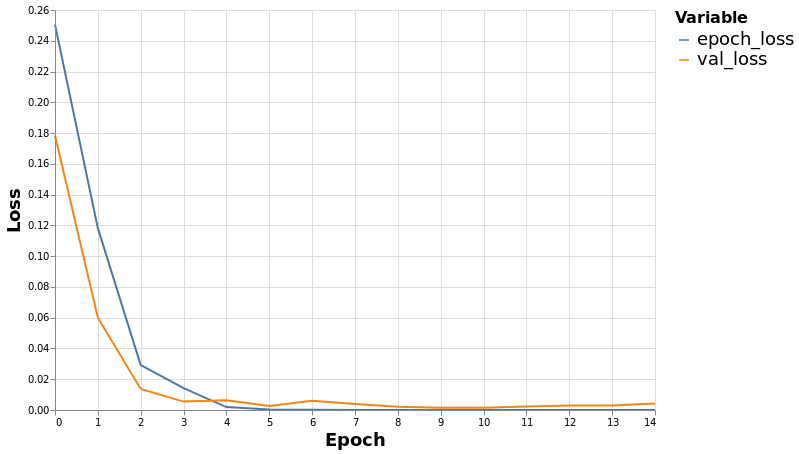

In [48]:
alt.Chart(history[["epoch_loss", "val_loss"]].reset_index().melt(id_vars=['index'], value_vars=['epoch_loss', 'val_loss']), height=400, width=600).mark_line(size=2).encode(
    alt.X("index:Q", axis=alt.Axis(title='Epoch', titleFontSize=18)),
    alt.Y("value", axis=alt.Axis(title="Loss", titleFontSize=18)),
    alt.Color("variable", legend=alt.Legend(title="Variable", labelFontSize=18, titleFontSize=16))
)

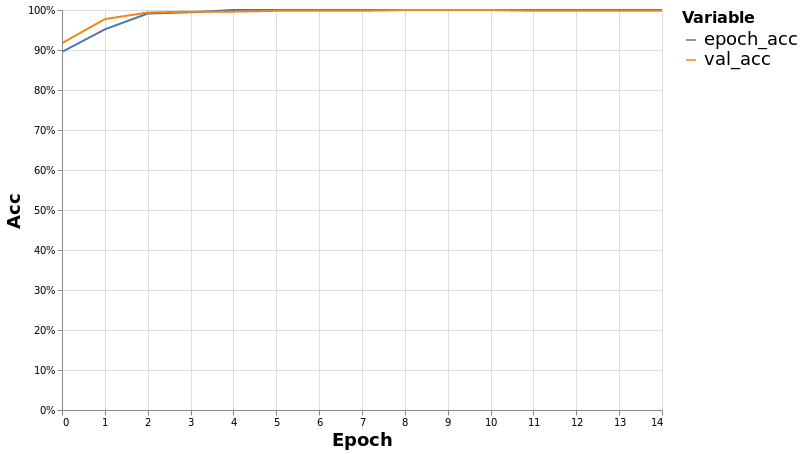

In [49]:
alt.Chart(history[["epoch_acc", "val_acc"]].reset_index().melt(id_vars=['index'], value_vars=['epoch_acc', 'val_acc']), height=400, width=600).mark_line().encode(
    alt.X("index:Q", axis=alt.Axis(title="Epoch", titleFontSize=18)),
    alt.Y("value", axis=alt.Axis(format='%', title="Acc", titleFontSize=18)),
    alt.Color("variable", legend=alt.Legend(title="Variable", labelFontSize=18, titleFontSize=16))
)

### Batch history

In [50]:
history = pd.DataFrame({k: dafs_pt_cnn_history[k] for k in dafs_pt_cnn_history if "batch" in k})
history

,batch_loss,batch_acc,batch_lr
0,6.988626e-01,0.320312,0.002995
1,4.596461e-01,0.898438,0.003000
2,3.326135e-01,0.921875,0.002995
3,3.319395e-01,0.914062,0.002979
4,2.110878e-01,0.937500,0.002952
5,2.140974e-01,0.945312,0.002916
6,4.442025e-01,0.882812,0.002869
7,2.482043e-01,0.914062,0.002813
8,2.835102e-01,0.898438,0.002748
9,2.599502e-01,0.921875,0.002674


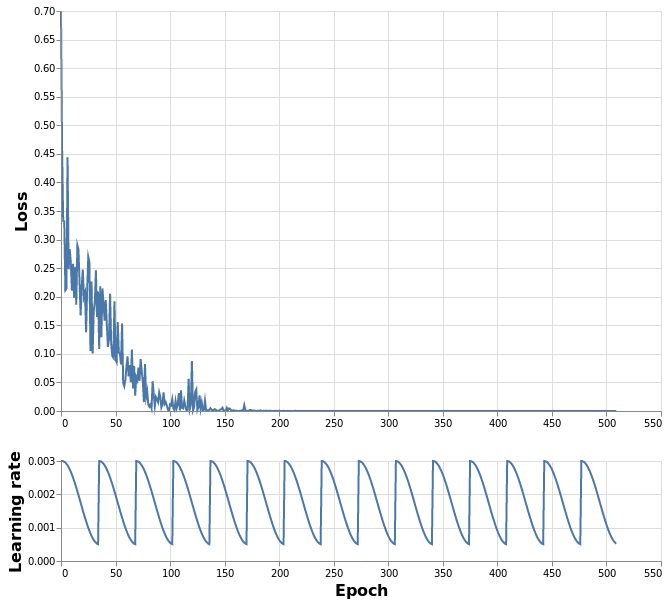

In [65]:
loss = alt.Chart(history["batch_loss"].reset_index(), height=400, width=600).mark_line().encode(
    alt.X("index:Q", axis=alt.Axis(title="", titleFontSize=18)),
    alt.Y("batch_loss", axis=alt.Axis(title="Loss", titleFontSize=16)),
)
lr = alt.Chart(history["batch_lr"].reset_index(), height=100, width=600).mark_line().encode(
    alt.X("index:Q", axis=alt.Axis(title="Epoch", titleFontSize=16)),
    alt.Y("batch_lr", axis=alt.Axis(title="Learning rate", titleFontSize=16)),
)
alt.vconcat(loss, lr)